In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import time
import os

In [2]:
# нужно для отображения графиков внутри ноутбука
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(style="whitegrid")

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Parameters
* General folder, 
* Data file (that contains all necessary data for summary statistics), 
* path to summary statistics folder and 
* path to graphs folder

In [3]:
path = r'D:\РЭШ\Research\PostThesis'
datafile = path + r'\data\var\bankdata_201709-202109_q_var_result.csv'
path_stat = path + r'\summary_stat'
path_graph = path + r'\graphs'

# Summary Statistics

Summary statistics includes the following tables:
1. Variables used for markup estimation
    * original dataset
    * after Winsorization (Winsorized)
2. Variables used for regressions on transmission of monetary policy
    * full (Winsorized) dataset
    * after IQR markup outliers removed
    
Note that second table consists of two separate parts: for credit markups and for deposit markups.

In [4]:
df = pd.read_csv(datafile)
print(len(df))
df = df.dropna(subset=['m_L_wins', 'm_D_wins'])
print(len(df))

657
641


In [5]:
# quarter to date format
df['date_from'] = pd.to_datetime(df['quarter'].str[:4]+'-'+((df['quarter'].str[-1].astype(int)-1)*3+1).astype(str) + '-01')
df['date_to'] = df['date_from']+pd.offsets.QuarterEnd()

### Summary Statistics for markup estimation variables

In [16]:
# Compare winsorization in Python and winsorization in Stata
df_stat = pd.DataFrame()

for col in ['NIE','NII','Loans','Deposits','Securities','II_Loans','IE_Deposits']: 
    df_temp = pd.DataFrame({'Variable': [col], 
                            #'Mean': [df[col].mean()/1e6], 
                            #'StDev': [df[col].std()/1e6], 
                            'Min': [(df[col]/df['Total_assets']).min()], 
                            'Max': [(df[col]/df['Total_assets']).max()],
                            #'Mean_wins': [df[col+'_wins'].mean()/1e6], 
                            #'StDev_wins': [df[col+'_wins'].std()/1e6], 
                            'Min_wins': [(df[col+'_wins']/df['Total_assets']).min()], 
                            'Max_wins': [(df[col+'_wins']/df['Total_assets']).max()], 
                            'Min_winsSt': [(df[col+'_winsSt']/df['Total_assets']).min()], 
                            'Max_winsSt': [(df[col+'_winsSt']/df['Total_assets']).max()]})
    df_stat = pd.concat([df_stat, df_temp], ignore_index = True)

df_stat

,Variable,Min,Max,Min_wins,Max_wins,Min_winsSt,Max_winsSt
0,NIE,-4.918678e-02,0.152997,-1.636916e-02,0.079950,-1.677087e-02,0.082044
1,NII,-6.928109e-02,0.200215,-5.308907e-04,0.081550,-8.980007e-04,0.082176
2,Loans,1.971460e-02,0.900130,1.524763e-01,0.900130,8.176915e-02,0.900130
3,Deposits,1.618725e-01,1.095627,2.526310e-01,1.040450,2.465410e-01,1.041243
4,Securities,1.446866e-07,0.874758,1.446866e-07,0.612711,1.446866e-07,0.618584
5,II_Loans,-1.759151e-02,0.161786,1.426617e-03,0.052070,1.172410e-03,0.053500
6,IE_Deposits,-6.588947e-02,0.074791,8.818941e-04,0.015076,8.262743e-04,0.015257


In [17]:
df_stat = pd.DataFrame()

# Absolute non-winsorized varibales (general statistics), in billions of rubles 2017
for col in ['Total_assets','Net_worth','Net_income','Sales']:    
    df_temp = pd.DataFrame({'Variable': [col], 
                            'Mean': [df[col].mean()/1e6], 
                            'StDev': [df[col].std()/1e6], 
                            'Min': [df[col].min()/1e6], 
                            'Max': [df[col].max()/1e6]})
    df_stat = pd.concat([df_stat, df_temp], ignore_index = True)

# To-be-winsorized absolute variables (used in markups estimation), in billions of rubles 2017
for col in ['NIE','NII','Loans','Deposits','Securities','II_Loans','IE_Deposits']: 
    df_temp = pd.DataFrame({'Variable': [col], 
                            'Mean': [df[col].mean()/1e6], 
                            'StDev': [df[col].std()/1e6], 
                            'Min': [df[col].min()/1e6], 
                            'Max': [df[col].max()/1e6],
                            'Mean_wins': [df[col+'_wins'].mean()/1e6], 
                            'StDev_wins': [df[col+'_wins'].std()/1e6], 
                            'Min_wins': [df[col+'_wins'].min()/1e6], 
                            'Max_wins': [df[col+'_wins'].max()/1e6]})
    df_stat = pd.concat([df_stat, df_temp], ignore_index = True)
    
# RUONIA
for col in ['ruo']:    
    df_temp = pd.DataFrame({'Variable': [col], 
                            'Mean': [df[col].mean()], 
                            'StDev': [df[col].std()], 
                            'Min': [df[col].min()], 
                            'Max': [df[col].max()]})
    df_stat = pd.concat([df_stat, df_temp], ignore_index = True) 
    
df_stat.to_excel(path_stat+r'\SumStat_Markups_wins.xlsx', index=False)

### Summary statistics for monetary policy transmission estimation

In [20]:
df_stat = pd.DataFrame()

# Loan/Credit variables
for col in ['Credit_cond_wins','lnL_wins','m_L_wins','Capital_ratio','Liquidity_ratio','Core_deposits_wins']:    
    df_temp = pd.DataFrame({'Variable': [col], 
                            'Mean': [df[col].mean()], 
                            'StDev': [df[col].std()], 
                            'Min': [df[col].min()], 
                            'Max': [df[col].max()],
                            'Obs': [df[col].count()],
                            'Mean_iqr': [df.loc[df['oliq_m_L_wins']==0][col].mean()], 
                            'StDev_iqr': [df.loc[df['oliq_m_L_wins']==0][col].std()], 
                            'Min_iqr': [df.loc[df['oliq_m_L_wins']==0][col].min()], 
                            'Max_iqr': [df.loc[df['oliq_m_L_wins']==0][col].max()], 
                            'Obs_iqr': [df.loc[df['oliq_m_L_wins']==0][col].count()]})
    df_stat = pd.concat([df_stat, df_temp], ignore_index = True) 

# Deposit variables
for col in ['Deposit_cond_wins','lnD_wins','m_D_wins','Capital_ratio','Liquidity_ratio','Core_deposits_wins']:    
    df_temp = pd.DataFrame({'Variable': [col], 
                            'Mean': [df[col].mean()], 
                            'StDev': [df[col].std()], 
                            'Min': [df[col].min()], 
                            'Max': [df[col].max()],
                            'Obs': [df[col].count()],
                            'Mean_iqr': [df.loc[df['oliq_m_D_wins']==0][col].mean()], 
                            'StDev_iqr': [df.loc[df['oliq_m_D_wins']==0][col].std()], 
                            'Min_iqr': [df.loc[df['oliq_m_D_wins']==0][col].min()], 
                            'Max_iqr': [df.loc[df['oliq_m_D_wins']==0][col].max()],
                            'Obs_iqr': [df.loc[df['oliq_m_D_wins']==0][col].count()]})
    df_stat = pd.concat([df_stat, df_temp], ignore_index = True) 
    
# General variables
for col in ['key_rate','CPI', 'GDP_growth']:
    df_temp = pd.DataFrame({'Variable': [col], 
                            'Mean': [df[col].mean()], 
                            'StDev': [df[col].std()], 
                            'Min': [df[col].min()], 
                            'Max': [df[col].max()]})
    df_stat = pd.concat([df_stat, df_temp], ignore_index = True) 

df_stat.to_excel(path_stat+r'\SumStat_Transmission_wins_iqr.xlsx')

# Graphs

## Banks number and Asset concentration

In [4]:
df_banksnum = pd.read_excel(path+r'\data\bank_number.xlsx', sheet_name = 'BanksNumber')
df_concentration = pd.read_excel(path+r'\data\bank_number.xlsx', sheet_name = 'AssetConcentration')

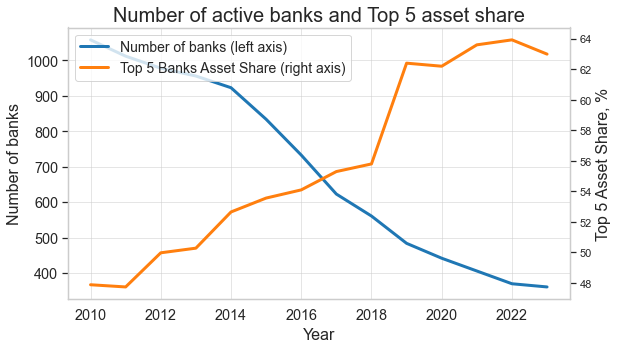

In [19]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (9, 5))
#plt.suptitle('Number of banks and Top 5 Asset concentration',fontsize=18)

line_banks, = ax.plot(df_banksnum['Year'], df_banksnum['ActiveBanks'], 
                      linewidth=3, label='Number of banks (left axis)', color='tab:blue')
ax.set_xlabel('Year',fontsize=16)
ax.set_ylabel('Number of banks',fontsize=16)

ax2 = ax.twinx()
line_share, = ax2.plot(df_concentration['Year'], df_concentration['First5 %'], 
                       linewidth=3, label='Top 5 Banks Asset Share (right axis)', color='tab:orange')
ax2.set_ylabel('Top 5 Asset Share, %',fontsize=16)

ax.tick_params(labelsize=14)
ax.grid(visible=True, alpha=0.5)
ax2.grid(visible=False) #, alpha=0.3, color='tab:orange')
ax.tick_params(labelsize='large')

lines=[line_banks, line_share]
labels=[line.get_label() for line in lines]
ax.legend(lines, labels, fontsize=14, loc=2)

ax.set_title('Number of active banks and Top 5 asset share',fontsize=20)

plt.savefig(path_graph+r'\BanksNum_Top5AssetShare.pdf', format="pdf", bbox_inches="tight")
plt.show()

## Scatter plots

Markups with outliers are presented in Summary statistics. For plots these are not informative, therefore all scatter plots are made on data with deleted IQR markup outliers.

### Markups vs markups

* Markups on winsorized dataset vs markups on full dataset
* Markups on winsorized dataset vs markups with no regression estimation
* Credit markups vs Deposit markups

In [6]:
df['lnTA'] = np.log(df['Total_assets'])

In [7]:
names = {'lnTA': 'ln Total Assets', 
         'lnL': 'ln Loans',
         'lnD': 'ln Deposits',
         'm_L_wins': 'Credit Markup (Wins)',
         'm_D_wins': 'Deposit Markup (Wins)',
         'm_L_CoF_wins': 'Credit Markup (CoD)',
         'm_L': 'Credit Markup (Init)',
         'm_D': 'Deposit Markup (Init)',
         'm_L_noreg': 'Credit Markup (No Reg)',
         'm_D_noreg': 'Deposit Markup (No Reg)', 
         'm_L_wins_break': 'Credit Markup (Break)', 
         'm_D_wins_break': 'Deposit Markup (Break)', 
         'm_L_wins_trend': 'Credit Markup (trend)', 
         'm_D_wins_trend': 'Deposit Markup (trend)', 
         'HHI': 'HHI'}

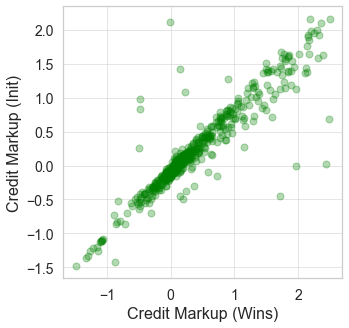

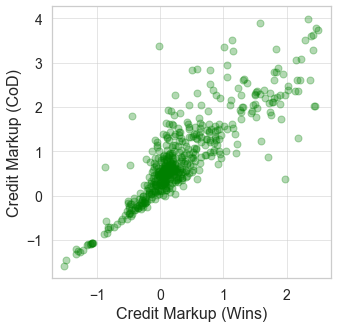

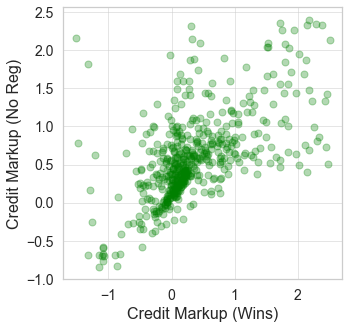

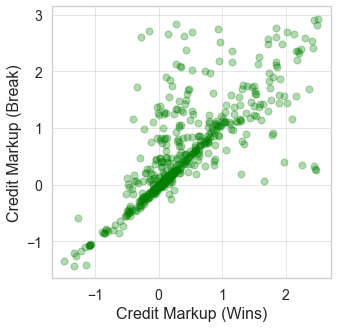

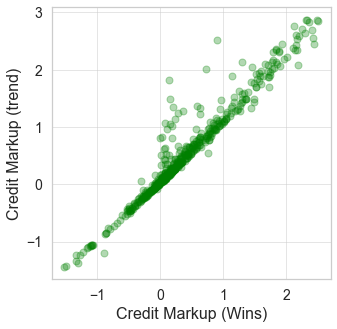

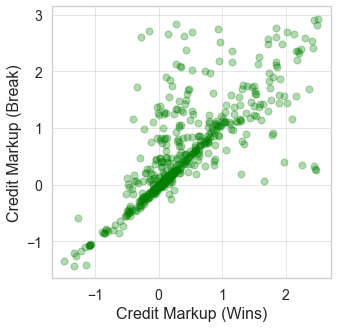

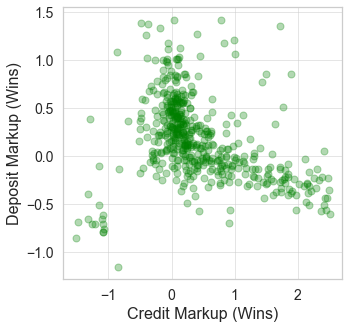

In [9]:
for x in ['m_L_wins']:
    for y in ['m_L', 'm_L_CoF_wins', 'm_L_noreg', 'm_L_wins_break', 'm_L_wins_trend', 'm_L_wins_break', 'm_D_wins']:
        fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (5, 5))

        #ax.scatter(x=df.loc[df['dt_year'] == year]['Total_assets'], y=df.loc[df['dt_year'] == year]['credit_markup'])
        ax.scatter(x=df.loc[(df['oliq_'+x]==0)&(df['oliq_'+y]==0)][x], 
                   y=df.loc[(df['oliq_'+x]==0)&(df['oliq_'+y]==0)][y], 
                   alpha=0.3, color = 'green', s=7**2)
        #, c=color, s=scale, label=color, alpha=0.3, edgecolors='none')
        #ax.set_title(names[x] + ' vs ' + names[y], fontsize=18)
        ax.set_xlabel(names[x], fontsize=16)
        ax.set_ylabel(names[y], fontsize=16)
        ax.grid(visible=True, alpha=0.5)
        ax.tick_params(labelsize=14)
        #ax.set_ylim(-10, 50)

        plt.savefig(path_graph + r'\scatterPy\Scatter.'+x+' vs '+y+'.pdf', format="pdf", bbox_inches="tight")
        plt.show()

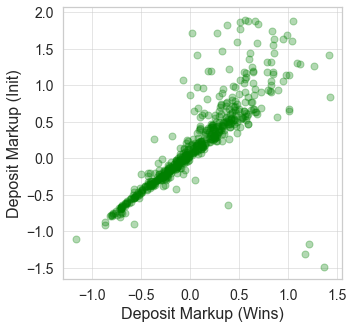

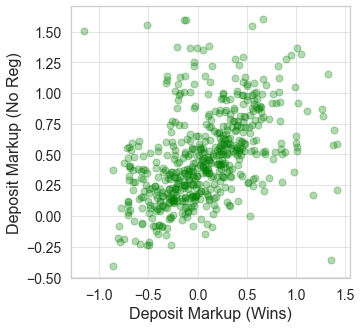

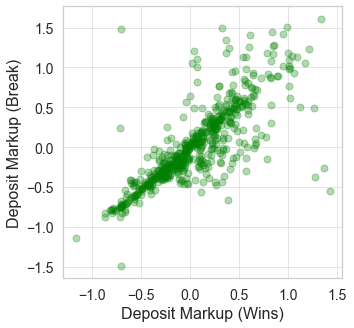

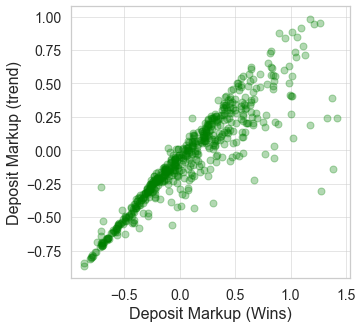

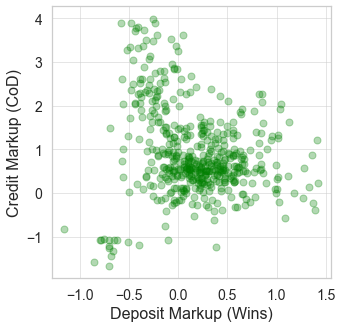

In [8]:
for x in ['m_D_wins']:
    for y in ['m_D', 'm_D_noreg', 'm_D_wins_break', 'm_D_wins_trend', 'm_L_CoF_wins']:
        fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (5, 5))

        #ax.scatter(x=df.loc[df['dt_year'] == year]['Total_assets'], y=df.loc[df['dt_year'] == year]['credit_markup'])
        ax.scatter(x=df.loc[(df['oliq_'+x]==0)&(df['oliq_'+y]==0)][x], 
                   y=df.loc[(df['oliq_'+x]==0)&(df['oliq_'+y]==0)][y], 
                   alpha=0.3, color = 'green', s=7**2)
        #, c=color, s=scale, label=color, alpha=0.3, edgecolors='none')
        #ax.set_title(names[x] + ' vs ' + names[y], fontsize=18)
        ax.set_xlabel(names[x], fontsize=16)
        ax.set_ylabel(names[y], fontsize=16)
        ax.grid(visible=True, alpha=0.5)
        ax.tick_params(labelsize=14)
        #ax.set_ylim(-10, 50)

        plt.savefig(path_graph + r'\scatterPy\Scatter.'+x+' vs '+y+'.pdf', format="pdf", bbox_inches="tight")
        plt.show()

### Markups vs Bank size
* Markups vs ln (Total Assets)
* Credit markups vs ln (Loans)
* Deposit markups vs ln (Deposits)

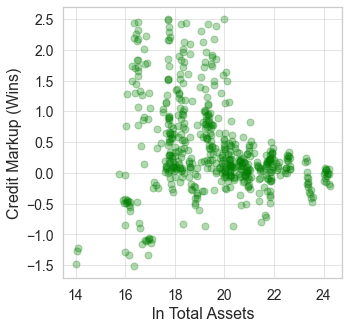

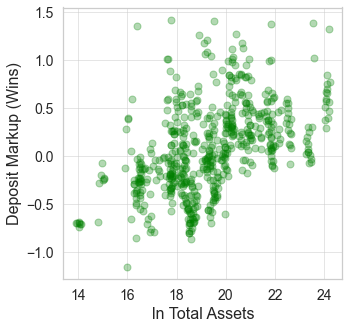

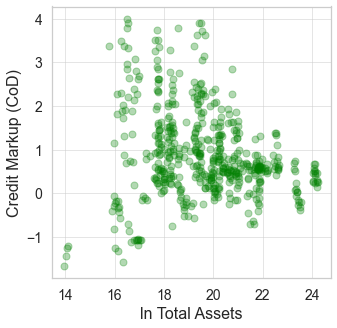

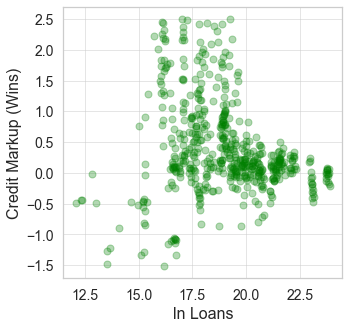

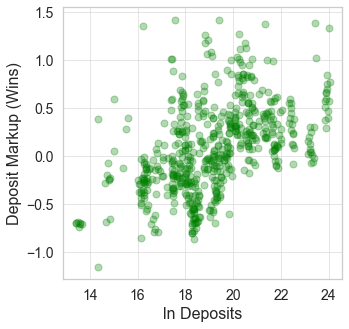

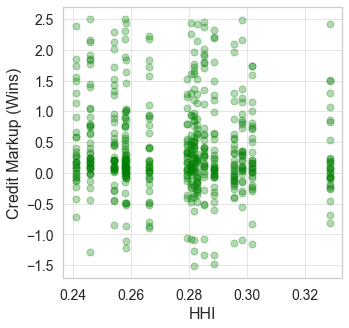

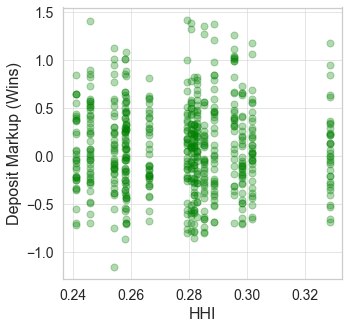

In [10]:
for x,y in [('lnTA', 'm_L_wins'),('lnTA', 'm_D_wins'),('lnTA','m_L_CoF_wins'),
            ('lnL', 'm_L_wins'),('lnD', 'm_D_wins'), 
            ('HHI','m_L_wins'), ('HHI','m_D_wins')]:
        fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (5, 5))

        #ax.scatter(x=df.loc[df['dt_year'] == year]['Total_assets'], y=df.loc[df['dt_year'] == year]['credit_markup'])
        ax.scatter(x=df.loc[df['oliq_'+y]==0][x], 
                   y=df.loc[df['oliq_'+y]==0][y], 
                   alpha=0.3, color = 'green', s=7**2)
        #, c=color, s=scale, label=color, alpha=0.3, edgecolors='none')
        #ax.set_title(names[x] + ' vs ' + names[y], fontsize=18)
        ax.set_xlabel(names[x], fontsize=16)
        ax.set_ylabel(names[y], fontsize=16)
        ax.grid(visible=True, alpha=0.5)
        ax.tick_params(labelsize=14)
        #ax.set_ylim(-10, 50)

        plt.savefig(path_graph + r'\scatterPy\Scatter.'+x+' vs '+y+'.pdf', format="pdf", bbox_inches="tight")
        plt.show()

## Trends

* Mean and std deviation of markups
* Median and quantiles of markups
* HHI
* Key rate
* RUONIA

### Markup trends

In [29]:
def plot_stats(df, col='credit_markup', title='Credit markup trend, 2017q4-2021q3', weight=None,
               filename=None, figsize=(18,8), ylim=(-1,8), quantiles=(10,90), show=True):
    '''
    The function plots statistics trends: mean, st deviation interval; median, quantile interval.
    '''
    
    fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (figsize[0], figsize[1]))
    #plt.suptitle('Credit Markups over Time',fontsize=18)
    
    # mean and standard deviation
    mean = df.groupby('quarter')[col].mean()
    std = df.groupby('quarter')[col].std()
    ax.plot(mean, label='Mean', linewidth=3)
    ax.fill_between(std.index, mean - std, mean + std, alpha=0.3, label='Standard Deviation Interval')
    
    # weighted mean
    if weight is not None:
        ax.plot(df.groupby('quarter').apply(lambda g: (g[col]*g[weight]).sum()/g[weight].sum()),
                label='Weighted Average', linewidth=3, color='#2ca02c')
    
    # median and quantiles
    ax.plot(df.groupby('quarter')[col].median(), label='Median', linewidth=3, color='#ff7f0e', alpha=0.9)
        
    q_min = quantiles[0]
    q_max = quantiles[1]

    ax.fill_between(std.index, 
                    df.groupby('quarter')[col].quantile(q_min/100), 
                    df.groupby('quarter')[col].quantile(q_max/100), 
                    color='#ff7f0e', alpha=0.3, label='Q'+str(q_min)+'-Q'+str(q_max)+' Interval')
    
    #q_min = 5
    #q_max = 95
    #ax.fill_between(std.index, 
    #                df.groupby('quarter')[col].quantile(q_min/100), 
    #                df.groupby('quarter')[col].quantile(q_max/100), 
    #                color='#ff7f0e', alpha=0.15, label='Q'+str(q_min)+'-Q'+str(q_max)+' Interval')
    
    #ax.plot(df.groupby('quarter')[col].max(), label='Max', linewidth=2.5)
    #ax.plot(df.groupby('quarter')[col].min(), label='Min', linewidth=2.5)
    ax.set_title(title ,fontsize=18)
    ax.set_xlabel('Time',fontsize=16)
    ax.set_ylabel('Value',fontsize=16)
    ax.legend(loc='upper left',fontsize=14)
    ax.tick_params(axis='x', labelrotation=45, labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(visible=True, alpha=0.5)
    
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    
    if filename is not None:
        plt.savefig(filename, format="pdf", bbox_inches="tight")
        
    if show:
        plt.show()
    else:
        plt.close()

In [30]:
def plot_top5(df, top5=[1481,1000,354,1326,3349], 
              nicks={1481: 'Сбер', 1000: 'ВТБ', 354: 'Газпромбанк', 1326: 'Альфа-Банк', 3349: 'РСХБ'},
              col='credit_markup', title='Top 5 credit markups, 2017q4-2021q3', 
              filename=None, figsize=(18,8), ylim=(0,3), show=True):
    '''
    Plots the graphs for banks, which regnum is in DataFrame top5
    '''
    
    
    fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (figsize[0], figsize[1]))
    #plt.suptitle('Top 5 banks Credit Markups',fontsize=18)
    
    
    for i in top5:
        df_i = df.loc[df['regnum']==i]
        ax.plot(df_i['quarter'], df_i[col], label=nicks[i], linewidth=3)
    ax.set_title(title ,fontsize=18)
    ax.set_xlabel('Time',fontsize=16)
    ax.set_ylabel('Value',fontsize=16)
    ax.legend(loc='upper left',fontsize=14)
    ax.tick_params(axis='x', labelrotation=45, labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(visible=True, alpha=0.5)
    
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    
    
    if filename is not None:
        plt.savefig(filename, format="pdf", bbox_inches="tight")
        
    if show:
        plt.show()
    else:
        plt.close()

In [14]:
def plot_distributions(df, col='credit_markup', title='Credit markups',
                        quarter=['2018q1', '2020q1'],
                        filename=None, figsize=(16,5), xlim=None, show=True):
    '''
    Plots distributions for 2 given quarters (quarter) of the given variable (col)
    '''
    
    
    fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (figsize[0], figsize[1]))

    # название для всей кратинки
    if title is not None:
        plt.suptitle(title,fontsize=18)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)

    # quarter[0]
    if xlim is not None:
        ax[0].hist(df.loc[df['quarter']==quarter[0]][col], bins=30, range=(xlim[0], xlim[1])) #, label='Credit Markups')
        ax[0].set_xlim(xlim[0], xlim[1])
    else:
        ax[0].hist(df.loc[df['quarter']==quarter[0]][col], bins=30) #, label='Credit Markups')
    ax[0].set_title(quarter[0],fontsize=16)
    ax[0].set_xlabel('Value',fontsize=14)
    ax[0].set_ylabel('Number of banks',fontsize=14)
    ax[0].grid(visible=True, alpha=0.5)
    #ax[0].legend(fontsize=10, loc=1)
        

    # quarter[1]
    if xlim is not None:
        ax[1].hist(df.loc[df['quarter']==quarter[1]][col], bins=30, range=(xlim[0], xlim[1])) #, label='Credit Markups')
        ax[1].set_xlim(xlim[0], xlim[1])
    else:
        ax[1].hist(df.loc[df['quarter']==quarter[1]][col], bins=30) #, label='Credit Markups')
    ax[1].set_title(quarter[1],fontsize=16)
    ax[1].set_xlabel('Value',fontsize=14)
    ax[1].set_ylabel('Number of banks',fontsize=14)
    ax[1].grid(visible=True, alpha=0.5)
    #ax[0].legend(fontsize=10, loc=1)
    
    
    
    if filename is not None:
        plt.savefig(filename, format="pdf", bbox_inches="tight")
    
    if show:
        plt.show()
    else:
        plt.close()

In [15]:
top5 = df.loc[df['quarter']=='2021q3'].nlargest(5, 'Total_assets')
top5

,regnum,dq,t,year,month,quarter,Name,Total_assets,Net_worth,Net_income,...,oliq_m_L_CoF_noreg,oliq_m_D_iq,oliq_m_L_iq,oliq_m_L_wins_trend,oliq_m_D_wins_trend,oliq_m_L_wins_break,oliq_m_D_wins_break,date_from,date_to,lnTA
224,1481,2021q3,16,2021,9,2021q3,Публичное акционерное общество «Сбербанк России»,3.357476e+10,4.671561e+09,3.066924e+08,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2021-07-01,2021-09-30,24.237040
176,1000,2021q3,16,2021,9,2021q3,Банк ВТБ (публичное акционерное общество),1.712566e+10,1.406254e+09,7.518237e+07,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2021-07-01,2021-09-30,23.563844
62,354,2021q3,16,2021,9,2021q3,«Газпромбанк» (Акционерное общество),6.824078e+09,6.943547e+08,3.586204e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-07-01,2021-09-30,22.643723
192,1326,2021q3,16,2021,9,2021q3,АКЦИОНЕРНОЕ ОБЩЕСТВО «АЛЬФА-БАНК»,4.469328e+09,5.728585e+08,2.654364e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-07-01,2021-09-30,22.220504
620,3349,2021q3,16,2021,9,2021q3,Акционерное общество «Российский Сельскохозяйс...,3.259747e+09,1.776734e+08,9.614198e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-07-01,2021-09-30,21.904915


In [16]:
# Bank nicknames
nick = {1481: 'Сбер', 1000: 'ВТБ', 354: 'Газпромбанк', 
        3349: 'РСХБ', 1326: 'Альфа-Банк', 2209: 'Открытие', 
        1978: 'МКБ', 1: 'ЮниКредит', 328: 'Россия', 3292: 'Райффайзенбанк'}

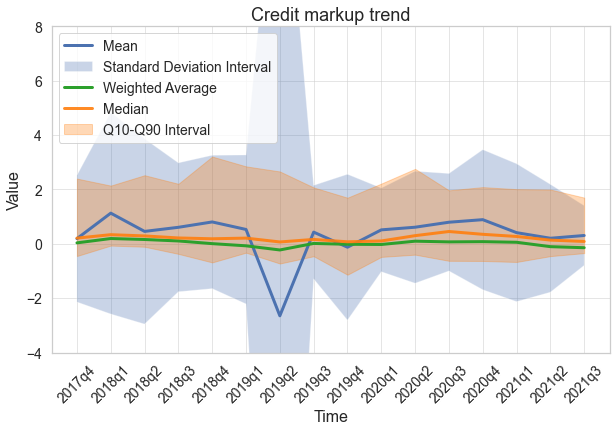

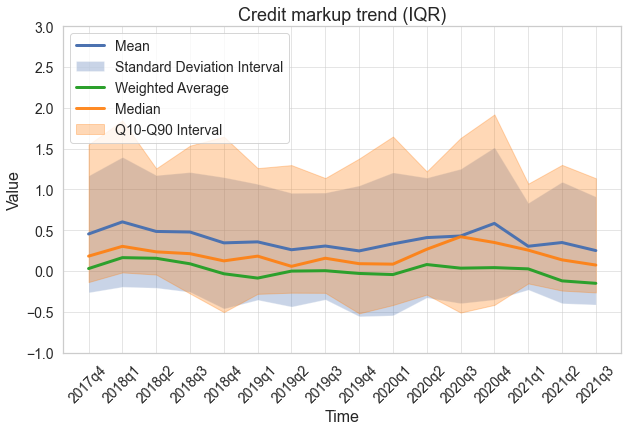

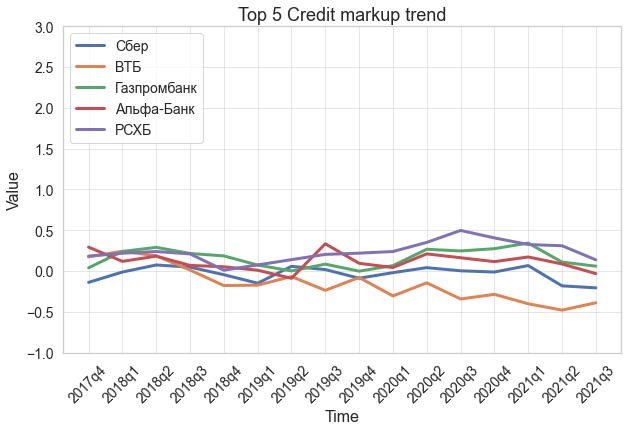

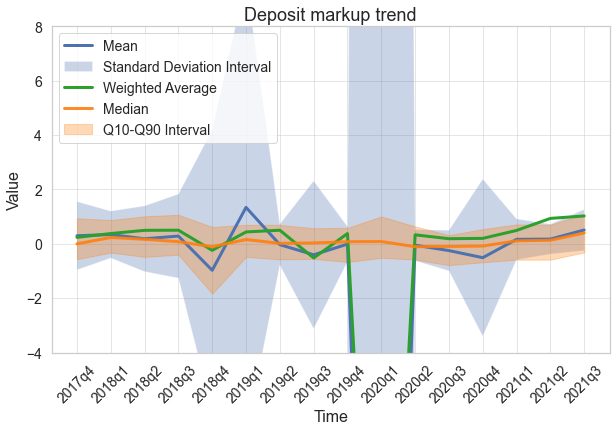

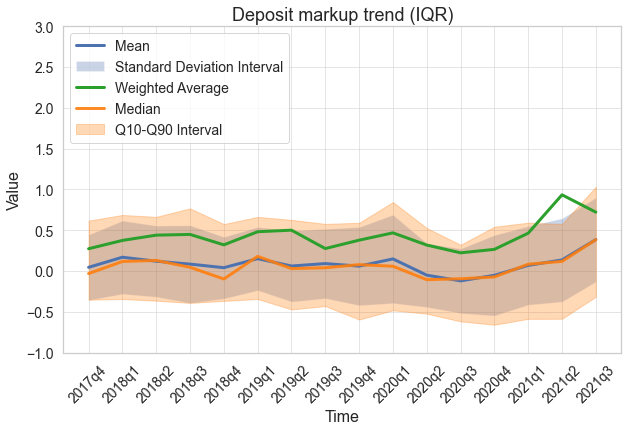

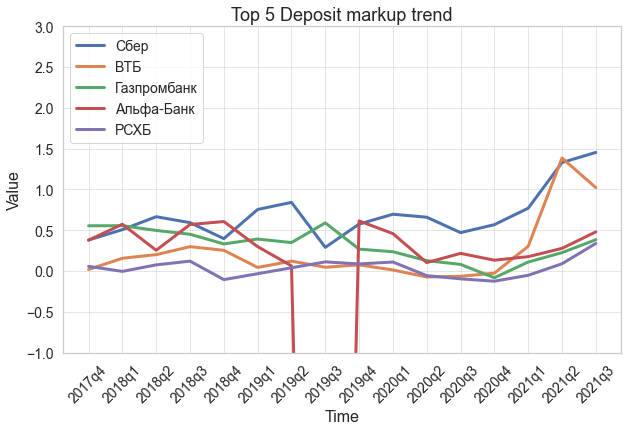

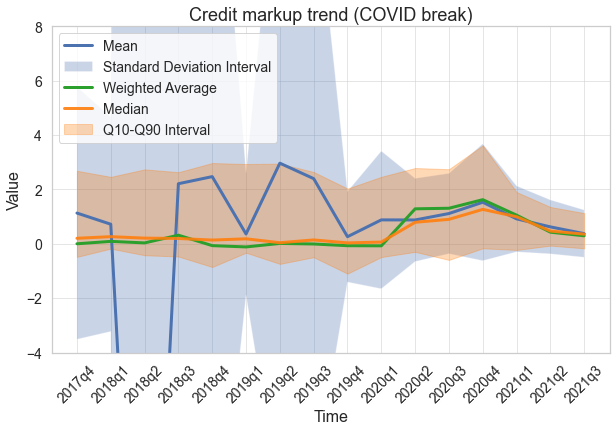

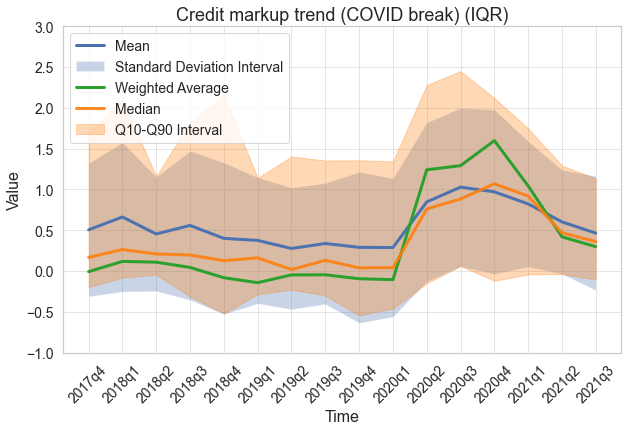

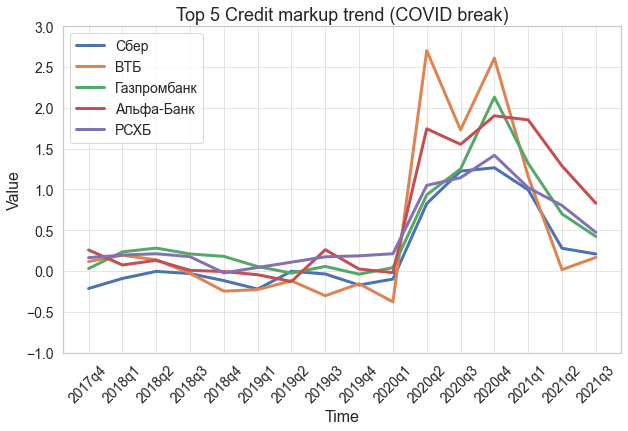

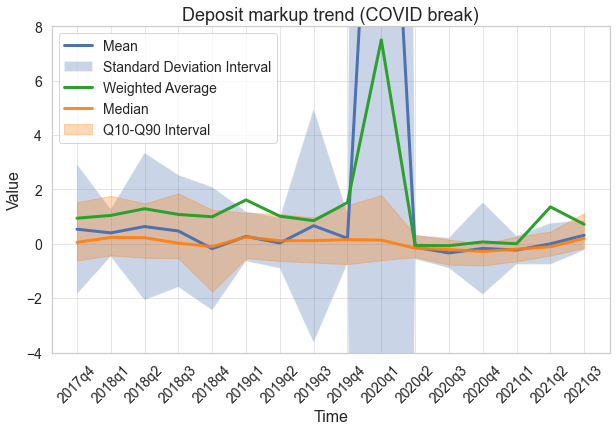

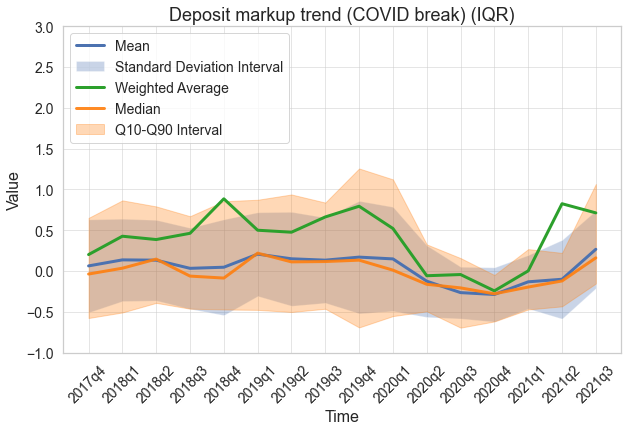

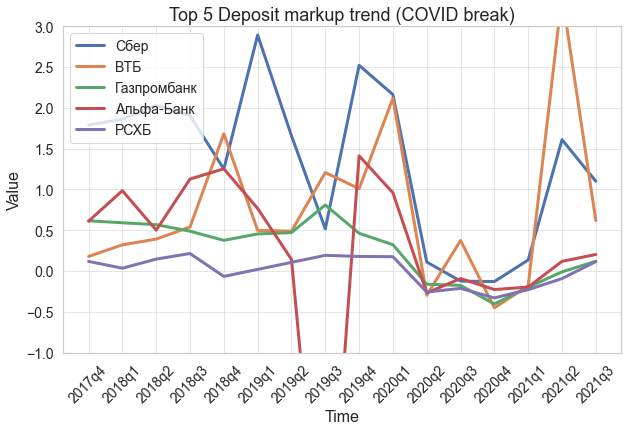

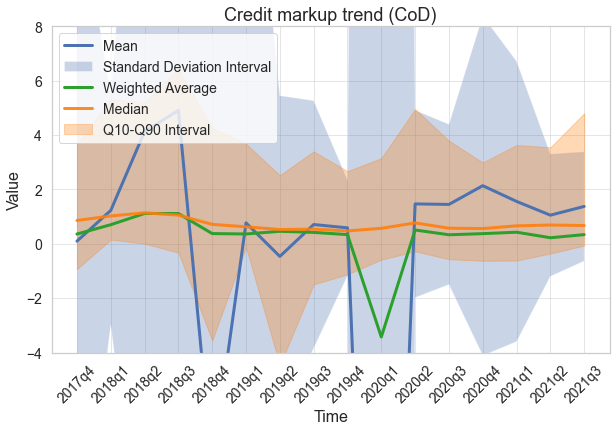

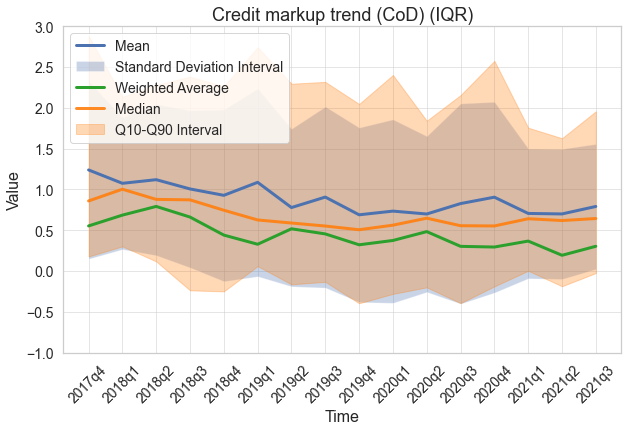

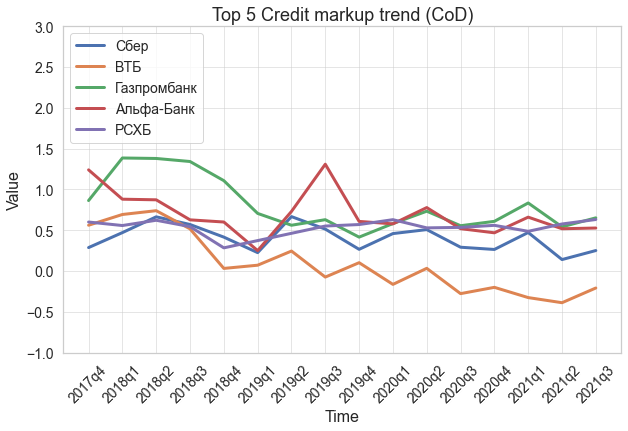

In [41]:
graph_names = {'m_L_wins': 'Credit markup trend', 
               'm_D_wins': 'Deposit markup trend',
               'm_L_CoF_wins': 'Credit markup trend (CoD)',
               'm_L_wins_break': 'Credit markup trend (COVID break)',
               'm_D_wins_break': 'Deposit markup trend (COVID break)'}

for x in ['m_L_wins','m_D_wins', 'm_L_wins_break', 'm_D_wins_break', 'm_L_CoF_wins']:
    plot_stats(df, col=x, weight='Total_assets',
               title=graph_names[x],
               filename=path_graph + r'\trendPy\Trend_' + x + r'.pdf', 
               figsize=(10,6), ylim=(-4,8), quantiles=(10,90), show=True)
    plot_stats(df.loc[df['oliq_'+x]==0], col=x, weight='Total_assets',
               title=graph_names[x] + ' (IQR)', 
               filename=path_graph + r'\trendPy\Trend_' + x + r'.IQR.pdf', 
               figsize=(10,6), ylim=(-1,3), quantiles=(10,90), show=True)
    plot_top5(df, top5=top5['regnum'], 
              nicks={1481: 'Сбер', 1000: 'ВТБ', 354: 'Газпромбанк', 1326: 'Альфа-Банк', 3349: 'РСХБ'},
              col=x, title='Top 5 '+graph_names[x], 
              filename=path_graph + r'\trendPy\Trend_' + x + r'.Top5.pdf', 
              figsize=(10,6), ylim=(-1,3), show=True)

### HHI

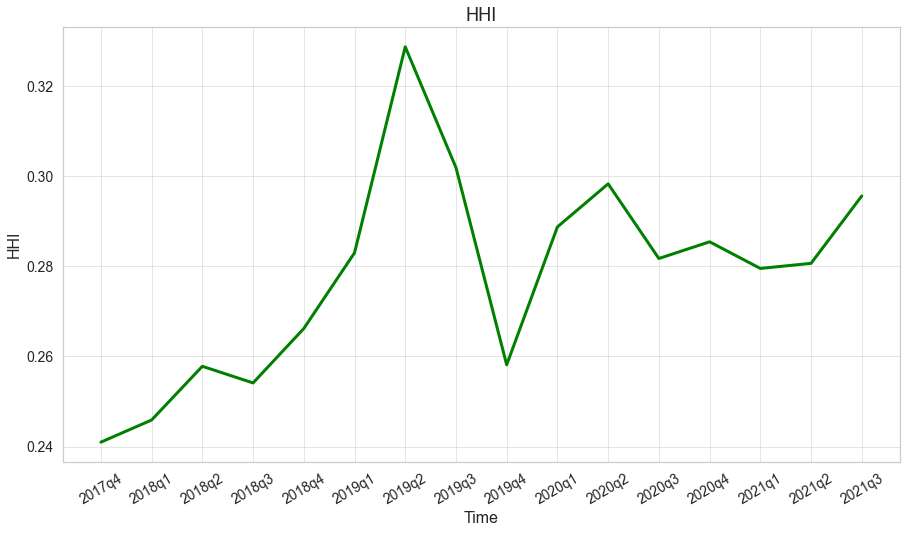

In [71]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (15, 8))
#plt.suptitle('Histograms of orders distribution and mean prices',fontsize=18)

ax.plot(df.groupby('quarter').mean().index, 
        df.groupby('quarter').mean()['HHI'], 
        label='HHI', linewidth=3, color='green')
ax.set_title('HHI',fontsize=18)
ax.set_xlabel('Time',fontsize=16)
ax.set_ylabel('HHI',fontsize=16)
ax.tick_params(axis='x', labelrotation=30, labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid(visible=True, alpha=0.5)
#ax[0].legend(fontsize=10, loc=1)
#plt.xticks(rotation=30)
plt.savefig(path_graph+r"\Trend_HHI.pdf", format="pdf", bbox_inches="tight")
plt.show()

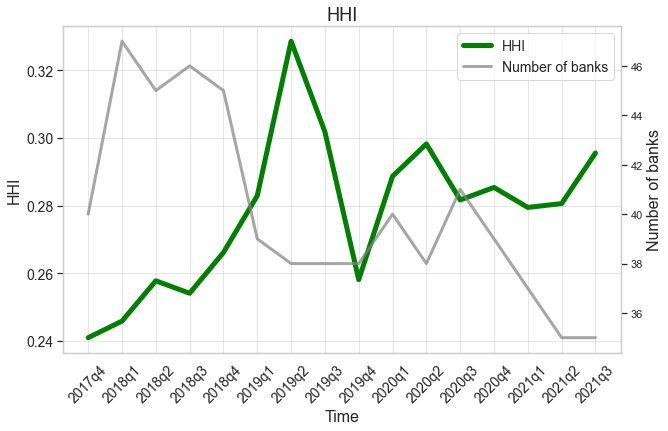

In [33]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (10, 6))
#plt.suptitle('Histograms of orders distribution and mean prices',fontsize=18)

line_HHI, = ax.plot(df.groupby('quarter').mean().index, 
        df.groupby('quarter').mean()['HHI'], 
        label='HHI', linewidth=5, color='green')
ax.set_xlabel('Time',fontsize=16)
ax.set_ylabel('HHI',fontsize=16)

ax2 = ax.twinx()
line_Banks, = ax2.plot(df.groupby('quarter').mean().index, 
         df.groupby('quarter').count()['regnum'], 
         label='Number of banks', linewidth=3, color='grey', alpha=0.7)
ax2.set_ylabel('Number of banks', fontsize=16)

ax.set_title('HHI',fontsize=18)
ax.tick_params(axis='x', labelrotation=45, labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid(visible=True, alpha=0.5)
ax2.grid(visible=False)

lines=[line_HHI, line_Banks]
labels=[line.get_label() for line in lines]
ax.legend(lines, labels, loc=1, fontsize=14)

#plt.xticks(rotation=30)
plt.savefig(path_graph+r"\Trend_HHI_Banks_num.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Key interest rate and RUONIA

In [34]:
# Key rate daily data
df_key_d = pd.read_excel(path+r'\data\external_data\original\key_rate_data.xlsx')
df_key_d = df_key_d.rename(columns={'Дата': 'date', 'Ставка': 'key_rate'})

# Key rate quarterly data
df_key_q = df.groupby('quarter').mean()[['key_rate']]
df_key_q['quarter'] = df_key_q.index
df_key_q['date_from'] = pd.to_datetime(df_key_q['quarter'].str[:4]+'-'+
                                       ((df_key_q['quarter'].str[-1].astype(int)-1)*3+1).astype(str) + '-01')
df_key_q['date_to'] = df_key_q['date_from']+pd.offsets.QuarterEnd()
df_key_q = df_key_q.melt(id_vars=['quarter','key_rate'], value_vars=['date_from','date_to'], 
                         var_name='date_type', value_name='date').sort_values('date')

In [35]:
# RUONIA daily data
df_ruo_d = pd.read_excel(path+r'\data\external_data\original\RC_F01_01_2017_T02_05_2024.xlsx')[['DT','ruo']]
df_ruo_d = df_ruo_d.rename(columns={'DT': 'date'}).sort_values('date')

# RUONIA quarterly data
df_ruo_q = df.groupby('quarter').mean()[['ruo']]
df_ruo_q['quarter'] = df_ruo_q.index
df_ruo_q['date_from'] = pd.to_datetime(df_ruo_q['quarter'].str[:4]+'-'+
                                       ((df_ruo_q['quarter'].str[-1].astype(int)-1)*3+1).astype(str) + '-01')
df_ruo_q['date_to'] = df_ruo_q['date_from']+pd.offsets.QuarterEnd()
df_ruo_q = df_ruo_q.melt(id_vars=['quarter','ruo'], value_vars=['date_from','date_to'], 
                         var_name='date_type', value_name='date').sort_values('date')

C:\Programming\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [36]:
# Daily data: set date limits
df_key_d = df_key_d.loc[(df_key_d['date']<=df_key_q['date'].max()) & (df_key_d['date']>=df_key_q['date'].min())]
df_ruo_d = df_ruo_d.loc[(df_ruo_d['date']<=df_ruo_q['date'].max()) & (df_ruo_d['date']>=df_ruo_q['date'].min())]

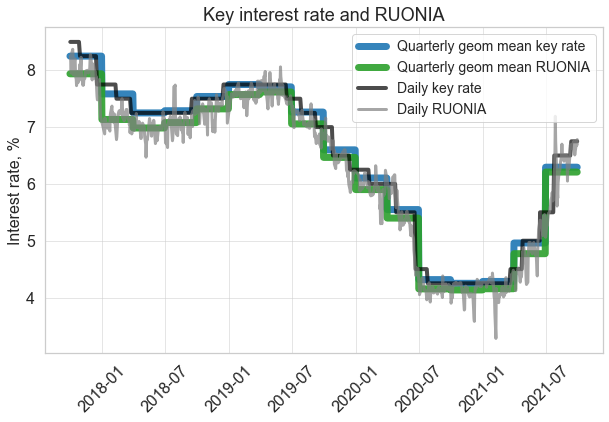

In [39]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (10, 6))

# название для всей кратинки
#plt.suptitle('Histograms of orders distribution and mean prices',fontsize=18)

#['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Key rate quarterly
ax.plot(df_key_q['date'], df_key_q['key_rate'], label='Quarterly geom mean key rate', 
        color='#1f77b4', linewidth=7, alpha=0.9) #, linestyle='--')

# RUONIA quarterly
ax.plot(df_ruo_q['date'], df_ruo_q['ruo'], label='Quarterly geom mean RUONIA', 
        color='#2ca02c', linewidth=7, alpha=0.9) #, linestyle='--')

# Key rate daily
ax.plot(df_key_d['date'], df_key_d['key_rate'], label='Daily key rate', 
        color='black', linewidth=4, alpha=0.7) #linestyle='--',

# RUONIA daily
ax.plot(df_ruo_d['date'], df_ruo_d['ruo'], label='Daily RUONIA', 
        color='grey', linewidth=3, alpha=0.7)


ax.set_title('Key interest rate and RUONIA',fontsize=18)
#ax.set_xlabel('quarter',fontsize=16)
ax.set_ylabel('Interest rate, %',fontsize=16)
ax.tick_params(axis='x', labelsize=16, labelrotation=45)
ax.tick_params(axis='y', labelsize=16)
ax.grid(visible=True, alpha=0.5)
ax.legend(fontsize=14, loc=1)

#plt.xticks(rotation=30)
plt.savefig(path_graph+r"\Key_rate_RUONIA.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [72]:
df

,regnum,dq,t,year,month,quarter,Name,Total_assets,Net_worth,Net_income,...,oliq_m_L_wins,oliq_m_D_winsSt,oliq_m_L_winsSt,oliq_m_L_CoF,oliq_m_L_CoF_wins,oliq_m_L_CoF_winsSt,oliq_m_L_CoF_noreg,oliq_m_D_iq,oliq_m_L_iq,lnTA
0,1,2017q4,1,2017,12,2017q4,Акционерное общество «ЮниКредит Банк»,1.189609e+09,1.872453e+08,4.963486e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.896890
1,1,2018q1,2,2018,3,2018q1,Акционерное общество «ЮниКредит Банк»,1.186804e+09,1.923812e+08,8.099290e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.894530
2,1,2018q2,3,2018,6,2018q2,Акционерное общество «ЮниКредит Банк»,1.196808e+09,1.857531e+08,2.799502e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.902924
3,1,2018q3,4,2018,9,2018q3,Акционерное общество «ЮниКредит Банк»,1.191612e+09,1.878942e+08,4.030878e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.898573
4,1,2018q4,5,2018,12,2018q4,Акционерное общество «ЮниКредит Банк»,1.322874e+09,1.926269e+08,5.645393e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.003073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,3450,2017q4,1,2017,12,2017q4,Банк «РЕСО Кредит» (Акционерное общество),6.957506e+06,3.124690e+06,7.498700e+04,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,15.755332
641,3450,2018q1,2,2018,3,2018q1,Банк «РЕСО Кредит» (Акционерное общество),9.591087e+06,3.037732e+06,1.268682e+04,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,16.076345
642,3450,2018q2,3,2018,6,2018q2,Банк «РЕСО Кредит» (Акционерное общество),8.980898e+06,2.925339e+06,4.055329e+04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,16.010610
643,3450,2018q3,4,2018,9,2018q3,Банк «РЕСО Кредит» (Акционерное общество),8.112689e+06,3.123008e+06,2.320494e+05,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,15.908940


# Monetary Policy Transmission variables

Plot dependent variables for monetary policy against Key interest rate

In [45]:
df = pd.read_csv(path + r'\data\var\bankdata_201709-202109_q_var_result_transmission.csv')
print(len(df))
df = df.dropna(subset=['m_L_wins', 'm_D_wins'])
print(len(df))

# quarter to date format
df['date_from'] = pd.to_datetime(df['quarter'].str[:4]+'-'+((df['quarter'].str[-1].astype(int)-1)*3+1).astype(str) + '-01')
df['date_to'] = df['date_from']+pd.offsets.QuarterEnd()

641
641


#### Levels

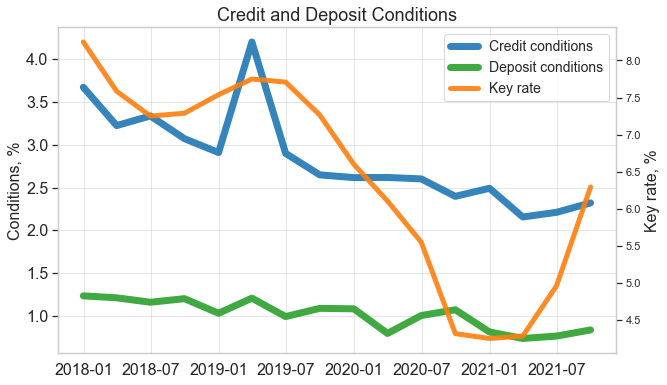

In [73]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (10, 6))

# название для всей кратинки
#plt.suptitle('Histograms of orders distribution and mean prices',fontsize=18)

#['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Credit condition
line_Credit, = ax.plot(df.groupby(['date_to']).mean().index, df.groupby(['quarter']).mean()['Credit_cond'],
                       label='Credit conditions', color='tab:blue', linewidth=7, alpha=0.9) #, linestyle='--')

# RUONIA quarterly
line_Deposit, = ax.plot(df.groupby(['date_to']).mean().index, df.groupby(['quarter']).mean()['Deposit_cond'],
                        label='Deposit conditions', color='tab:green', linewidth=7, alpha=0.9) #, linestyle='--')
ax.set_ylabel('Conditions, %', fontsize=16)

# Key rate daily
ax2 = ax.twinx()
line_keyrate, = ax2.plot(df.groupby(['date_to']).mean().index, df.groupby('quarter').mean()['key_rate'],
                         label='Key rate', color='tab:orange', linewidth=5, alpha=0.9)
ax2.set_ylabel('Key rate, %', fontsize=16)



ax.set_title('Credit and Deposit Conditions',fontsize=18)
#ax.set_xlabel('quarter',fontsize=16)
#ax.set_ylabel('interest rate, %',fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(visible=True, alpha=0.5)
ax2.grid(visible=False)

lines=[line_Credit, line_Deposit, line_keyrate]
labels=[line.get_label() for line in lines]
ax.legend(lines, labels, loc=1, fontsize=14)

#plt.xticks(rotation=30)
plt.savefig(path_graph+r"\Credit_Deposit_cond.pdf", format="pdf", bbox_inches="tight")
plt.show()

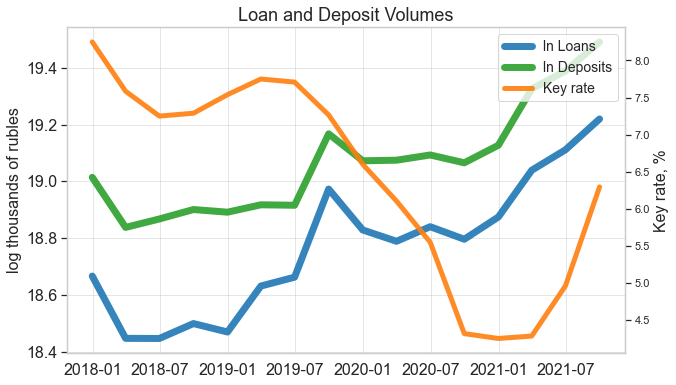

In [72]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (10, 6))

# название для всей кратинки
#plt.suptitle('Histograms of orders distribution and mean prices',fontsize=18)

#['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Credit condition
line_Credit, = ax.plot(df.groupby(['date_to']).mean().index, df.groupby(['quarter']).mean()['lnL'],
                       label='ln Loans', color='tab:blue', linewidth=7, alpha=0.9) #, linestyle='--')

# RUONIA quarterly
line_Deposit, = ax.plot(df.groupby(['date_to']).mean().index, df.groupby(['quarter']).mean()['lnD'],
                        label='ln Deposits', color='tab:green', linewidth=7, alpha=0.9) #, linestyle='--')
ax.set_ylabel('log thousands of rubles', fontsize=16)

# Key rate daily
ax2 = ax.twinx()
line_keyrate, = ax2.plot(df.groupby(['date_to']).mean().index, df.groupby('quarter').mean()['key_rate'],
                         label='Key rate', color='tab:orange', linewidth=5, alpha=0.9)
ax2.set_ylabel('Key rate, %', fontsize=16)



ax.set_title('Loan and Deposit Volumes',fontsize=18)
#ax.set_xlabel('quarter',fontsize=16)
#ax.set_ylabel('interest rate, %',fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(visible=True, alpha=0.5)
ax2.grid(visible=False)

lines=[line_Credit, line_Deposit, line_keyrate]
labels=[line.get_label() for line in lines]
ax.legend(lines, labels, loc=1, fontsize=14)

#plt.xticks(rotation=30)
plt.savefig(path_graph+r"\lnLoans_lnDeposits.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### First Differences

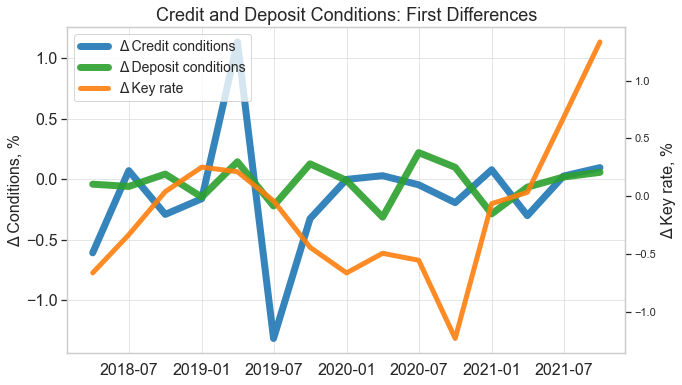

In [75]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (10, 6))

# название для всей кратинки
#plt.suptitle('Histograms of orders distribution and mean prices',fontsize=18)

#['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Credit condition
line_Credit, = ax.plot(df.groupby(['date_to']).mean().index, df.groupby(['date_to']).mean()['D_Credit_cond'],
                       label='Δ Credit conditions', color='tab:blue', linewidth=7, alpha=0.9) #, linestyle='--')

# RUONIA quarterly
line_Deposit, = ax.plot(df.groupby(['date_to']).mean().index, df.groupby(['date_to']).mean()['D_Deposit_cond'],
                        label='Δ Deposit conditions', color='tab:green', linewidth=7, alpha=0.9) #, linestyle='--')
ax.set_ylabel('Δ Conditions, %', fontsize=16)

# Key rate daily
ax2 = ax.twinx()
line_keyrate, = ax2.plot(df.groupby(['date_to']).mean().index, df.groupby('date_to').mean()['D_key_rate'],
                         label='Δ Key rate', color='tab:orange', linewidth=5, alpha=0.9)
ax2.set_ylabel('Δ Key rate, %', fontsize=16)



ax.set_title('Credit and Deposit Conditions: First Differences',fontsize=18)
#ax.set_xlabel('quarter',fontsize=16)
#ax.set_ylabel('interest rate, %',fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(visible=True, alpha=0.5)
ax2.grid(visible=False)

lines=[line_Credit, line_Deposit, line_keyrate]
labels=[line.get_label() for line in lines]
ax.legend(lines, labels, loc=2, fontsize=14)

#plt.xticks(rotation=30)
plt.savefig(path_graph+r"\Credit_Deposit_cond_diff.pdf", format="pdf", bbox_inches="tight")
plt.show()

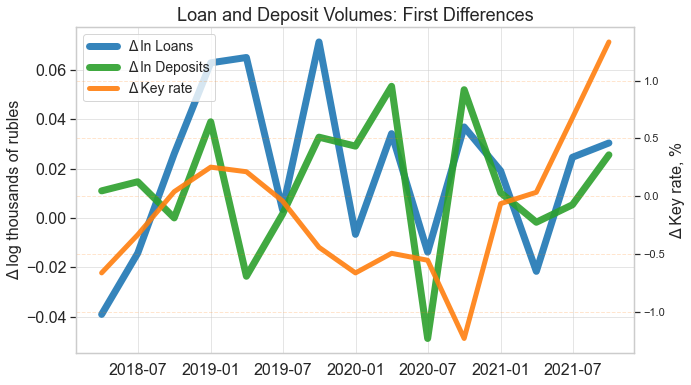

In [70]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (10, 6))

# название для всей кратинки
#plt.suptitle('Histograms of orders distribution and mean prices',fontsize=18)

#['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Credit condition
line_Credit, = ax.plot(df.groupby(['date_to']).mean().index, df.groupby(['date_to']).mean()['D_lnL'],
                       label='Δ ln Loans', color='tab:blue', linewidth=7, alpha=0.9) #, linestyle='--')

# RUONIA quarterly
line_Deposit, = ax.plot(df.groupby(['date_to']).mean().index, df.groupby(['date_to']).mean()['D_lnD'],
                        label='Δ ln Deposits', color='tab:green', linewidth=7, alpha=0.9) #, linestyle='--')
ax.set_ylabel('Δ log thousands of rubles', fontsize=16)

# Key rate daily
ax2 = ax.twinx()
line_keyrate, = ax2.plot(df.groupby(['date_to']).mean().index, df.groupby('date_to').mean()['D_key_rate'],
                         label='Δ Key rate', color='tab:orange', linewidth=5, alpha=0.9)
ax2.set_ylabel('Δ Key rate, %', fontsize=16)



ax.set_title('Loan and Deposit Volumes: First Differences',fontsize=18)
#ax.set_xlabel('quarter',fontsize=16)
#ax.set_ylabel('interest rate, %',fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(visible=True, alpha=0.5)
ax2.grid(visible=True, alpha=0.2, color='tab:orange', linestyle='--')

lines=[line_Credit, line_Deposit, line_keyrate]
labels=[line.get_label() for line in lines]
ax.legend(lines, labels, loc=2, fontsize=14)

#plt.xticks(rotation=30)
plt.savefig(path_graph+r"\lnLoans_lnDeposits_diff.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [4]:
pd.read_csv(path_stat+ r'\summary_stats_full.csv', delimiter=';', header=1).rename(columns={'Unnamed: 0': 'Variable'})

,Variable,Obs,Mean,SD,Min,Median,Max
0,Credit_cond,641,2.857672,1.983338,-2.746305,2.470371,31.276600
1,Deposit_cond,641,1.023833,0.701631,-8.601720,1.043933,9.919147
2,Credit_cond_wins,641,2.788921,1.459353,0.222717,2.468956,10.086880
3,Deposit_cond_wins,641,1.039053,0.348392,0.084761,1.043933,2.105119
4,lnD,641,19.057830,2.127611,13.421710,19.050910,24.054590
5,lnL,641,18.749070,2.181987,12.084220,18.772580,23.878670
6,lnL_wins,641,18.762030,2.149550,13.390590,18.772580,23.878670
7,lnD_wins,641,19.059690,2.122661,13.421710,19.050910,24.054590
8,m_D,641,0.272342,9.361319,-96.920430,0.152297,183.383600
9,m_L,641,0.229192,5.904865,-96.700430,0.119556,58.413950


In [5]:
csv_files = [f for f in os.listdir(path_stat) if f.endswith('.csv')]
print(csv_files)

for f in csv_files:
    df = pd.read_csv(path_stat+r'\\'+f, delimiter=';', header=1).rename(columns={'Unnamed: 0': 'Variable'})
    df.to_excel(path_stat+r'\\'+f.replace(".csv", ".xlsx"), index=False)

['summary_stats_full.csv', 'summary_stats_m_D_IQR.csv', 'summary_stats_m_D_iq_IQR.csv', 'summary_stats_m_D_iq_Q.csv', 'summary_stats_m_D_noreg_IQR.csv', 'summary_stats_m_D_noreg_Q.csv', 'summary_stats_m_D_Q.csv', 'summary_stats_m_D_wins_IQR.csv', 'summary_stats_m_D_wins_Q.csv', 'summary_stats_m_L_IQR.csv', 'summary_stats_m_L_iq_IQR.csv', 'summary_stats_m_L_iq_Q.csv', 'summary_stats_m_L_noreg_IQR.csv', 'summary_stats_m_L_noreg_Q.csv', 'summary_stats_m_L_Q.csv', 'summary_stats_m_L_wins_IQR.csv', 'summary_stats_m_L_wins_Q.csv']
